# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data.duplicated().sum()

0

In [6]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
data['real_age'].mode()

0    30
Name: real_age, dtype: int64

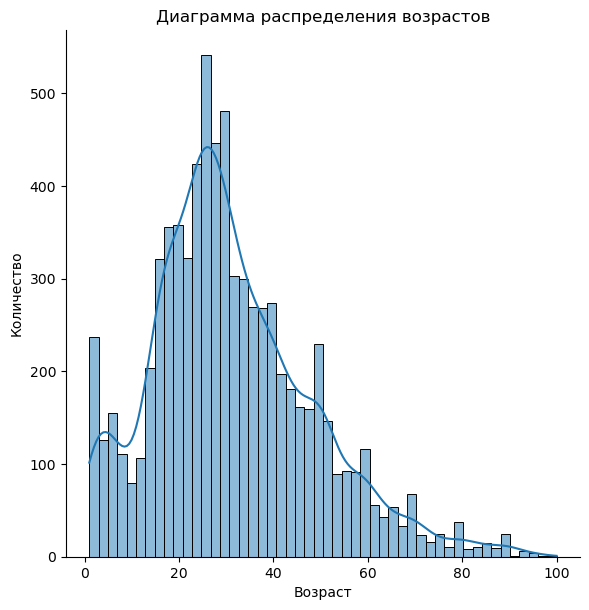

In [8]:
sns.displot(data['real_age'], kde=True, height=6, bins=50)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Диаграмма распределения возрастов')
plt.show()

In [9]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [10]:
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)

val_datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [11]:
img, age = next(train_datagen_flow)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, созданы датагенераторы и получен батч данных.</div>

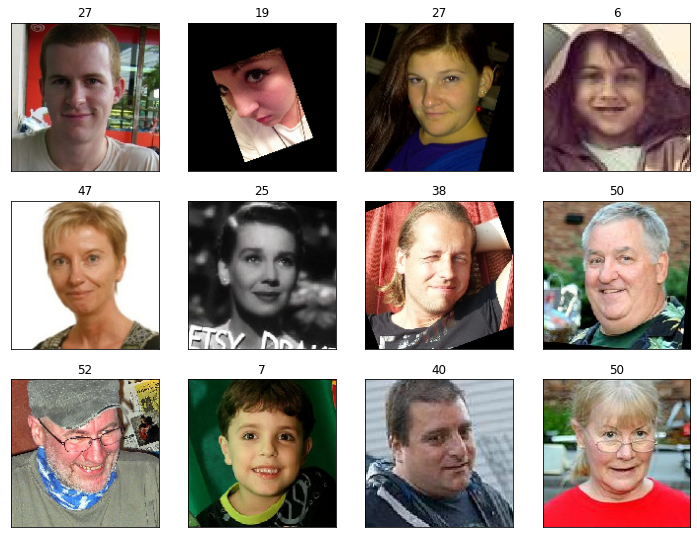

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(img[i])
    plt.title(age[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** Размер датасета 7591 строк, вполне достаточно, чтобы обучить хорошую модель. Пропусков нет. Дубликатов нет. Минимальный возраст - 1 год, максимальный - 100 лет. Мода распределения 30 лет. Распределение имеет асимметричную форму, смещено влево - модель будет точнее угадывать молодых, но уже взрослых людей, чем пожилых или детей.

Некоторые фотографии имеют плохое качество, что может ухудшить качество предсказания модели.

Улучшить качество модели может аугментация, конкретно, горизонтальная.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255,
        horizontal_flip=True
    )
    data = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        target_size=(224, 224),
        subset='training',
        seed=12345
        )
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255
    )
    data = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345
        )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    optimizer = Adam(0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='relu', input_dim=10))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 59s - loss: 203.0334 - mae: 10.3127 - val_loss: 359.1871 - val_mae: 14.0813
Epoch 2/10
356/356 - 45s - loss: 81.9027 - mae: 6.8537 - val_loss: 119.1225 - val_mae: 8.3186
Epoch 3/10
356/356 - 45s - loss: 55.7625 - mae: 5.6867 - val_loss: 101.4787 - val_mae: 7.8564
Epoch 4/10
356/356 - 44s - loss: 41.3564 - mae: 4.9375 - val_loss: 100.0028 - val_mae: 7.4063
Epoch 5/10
356/356 - 41s - loss: 32.0070 - mae: 4.3078 - val_loss: 76.5829 - val_mae: 6.6413
Epoch 6/10
356/356 - 40s - loss: 24.1549 - mae: 3.7402 - val_loss: 76.9116 - val_mae: 6.4318
Epoch 7/10
356/356 - 43s - loss: 18.9921 - mae: 3.3546 - val_loss: 78.5676 - val_mae: 6.8192
Epoch 8/10
356/356 - 47s - loss: 15.0689 - mae: 2.9299 - val_loss: 62.6685 - val_mae: 5.8349
Epoch 9/10
356/356 - 46s - loss: 13.7368 - mae: 2.8181 - val_loss: 73.1068 - val_mae: 6.5961
Epoch 10/10
356/356 - 45s - loss: 12.4037 - mae: 2.6593 - val_loss: 62.8229 - val_mae: 5.9173
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 62.8229 - mae: 5.9173
Test MAE: 5.9173

```

## Анализ обученной модели

Модель показала на 8 эпохе MAE 5.8349 и на 10 эпохе MAE 5.9173 при разделении на обучающую выборку (75%) и тестовую (25%). Использовалась аугментация, только горизонтальный флип. Размер батча 16.

Использовался костяк с ResNet50, после добавлялся GlobalAveragePooling2D, слой с 10 нейронами и выходной слой с 1 нейроном.

Модель подходит для рекомендаций товаров определенной возрастной группе, но с контролем возраста для продажи алкоголя могут возникнуть проблемы.